<a href="https://colab.research.google.com/github/NurIzzati11/GenderXEmotion/blob/main/GenderXEmotion(Gender)EXPERIMENT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GenderXEmotion Experiment 1 (Gender)**

- Building own model from a dataset obtained from github
- 58k pictures of both man and woman

# **Importing packages & early initialization** 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
%matplotlib inline
import tensorflow as tf
import datetime
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array

#inception_weight_path='https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [2]:
!git clone https://github.com/NurIzzati11/male-female-faceDataset.git

Cloning into 'male-female-faceDataset'...
remote: Enumerating objects: 58657, done.
remote: Total 58657 (delta 0), reused 0 (delta 0), pack-reused 58657
Receiving objects: 100% (58657/58657), 261.44 MiB | 26.08 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (58659/58659), done.


In [3]:
epochs = 50
lr = 1e-3
batchSize=128
data = []
labels = []
size= 224 #height/width

# **Image Data Generator**

In [4]:
trainDatagen = ImageDataGenerator(horizontal_flip=True,
                                  width_shift_range=0.4,
                                  height_shift_range=0.4,
                                  zoom_range=0.3,
                                  rotation_range=20,
                                  rescale=1/255
                                  )

In [5]:
testGen = ImageDataGenerator(rescale=1/255)

In [6]:
targetSize=(size,size)

In [7]:
trainGen = trainDatagen.flow_from_directory(
    directory='/content/male-female-faceDataset/Training',
    target_size=targetSize,
    batch_size=batchSize,
    class_mode ='binary'
)

Found 47009 images belonging to 2 classes.


In [8]:
validationGen= testGen.flow_from_directory(
    directory='/content/male-female-faceDataset/Validation',
    target_size=targetSize,
    batch_size=batchSize,
    class_mode ='binary'
    )

Found 11649 images belonging to 2 classes.


# **Building ML Model (Gender)**

In [9]:
model=Sequential()
model.add(InceptionV3(include_top=False,pooling='avg',weights='imagenet'))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(2048,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1,activation='sigmoid'))

model.layers[0].trainable=False

87924736/87910968 [==============================] - 1s 0us/step


In [10]:
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# **Creating Callbacks**

In [11]:
chk_path = 'GenNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# **Model Training**

In [12]:
hist=model.fit(trainGen,steps_per_epoch=len(trainGen.filenames)//batchSize,
          epochs=10,
          validation_data=validationGen,
          validation_steps=len(validationGen.filenames)//batchSize,
          callbacks=callbacks)

Epoch 1/10
367/367 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.8445
Epoch 1: val_loss improved from inf to 0.22117, saving model to GenNet.h5
367/367 [==============================] - 723s 2s/step - loss: 0.3819 - accuracy: 0.8445 - val_loss: 0.2212 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 2/10
367/367 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8686
Epoch 2: val_loss improved from 0.22117 to 0.19542, saving model to GenNet.h5
367/367 [==============================] - 691s 2s/step - loss: 0.3097 - accuracy: 0.8686 - val_loss: 0.1954 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 3/10
367/367 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.8768
Epoch 3: val_loss did not improve from 0.19542
367/367 [==============================] - 732s 2s/step - loss: 0.2926 - accuracy: 0.8768 - val_loss: 0.1959 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 4/10
367/367 [==============================] - ETA: 0s - loss: 0.2884 -

# **Loss Accurancy Plot** 

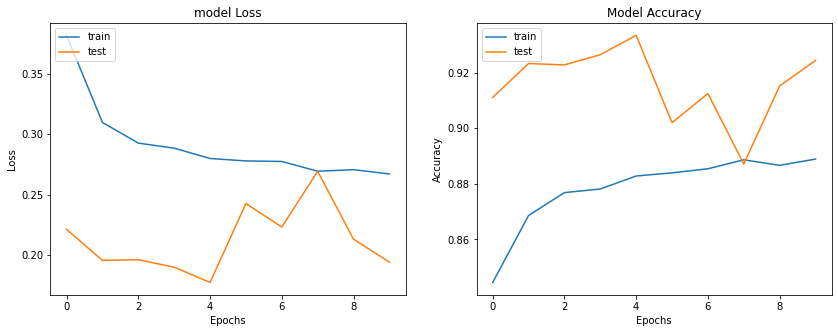

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Model Evaluation**

In [29]:
train_loss, train_accu = model.evaluate(trainGen)
test_loss, test_accu = model.evaluate(validationGen)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

92/92 [==============================] - 53s 572ms/step - loss: 0.1940 - accuracy: 0.9244
final train accuracy = 89.23 , validation accuracy = 92.44


# **Test Model**

In [36]:
img_path='/content/male-female-faceDataset/Validation/female/112944.jpg.jpg'

In [37]:
from urllib.request import proxy_bypass
def get_classes(data):
  prob=model.predict(data)[0][0]

  if prob<=0.5:
    return 'female', (1-prob)*100
  else:
    return 'male', prob*100

In [38]:
def get_prediction(img_path):
  img= load_img(img_path,target_size=(size,size,3))
  plt.imshow(img)
  img= img_to_array(img)
  img = img/225.0
  img = img.reshape(1,size,size,3)

  pred,prob = get_classes(img)
  return pred,prob                   

('female', 99.8600912746042)

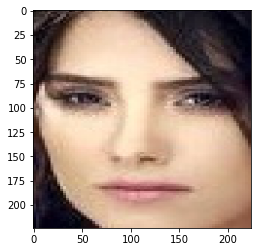

In [39]:
get_prediction(img_path)